## ConvNet

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.examples.tutorials.mnist import input_data

### Load data

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
trX = trX.reshape(-1, 28, 28, 1)  # 28x28x1 input img
teX = teX.reshape(-1, 28, 28, 1)  # 28x28x1 input img

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Helper functions

In [4]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

def get_layer(X, w, p_keep_conv):
    layer = tf.nn.relu(tf.nn.conv2d(X, w,                       # l1a shape=(?, 28, 28, 32)
                        strides=[1, 1, 1, 1], padding='SAME'))
    layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1],              # l1 shape=(?, 14, 14, 32)
                        strides=[1, 2, 2, 1], padding='SAME')
    layer = tf.nn.dropout(layer, p_keep_conv)
    return layer

### Build graph

In [5]:
X = tf.placeholder("float", [None, 28, 28, 1])
Y = tf.placeholder("float", [None, 10])

p_keep_conv = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")

w = init_weights([3, 3, 1, 32])       # 3x3x1 conv, 32 outputs
w2 = init_weights([3, 3, 32, 64])     # 3x3x32 conv, 64 outputs
w3 = init_weights([3, 3, 64, 128])    # 3x3x32 conv, 128 outputs
w4 = init_weights([128 * 4 * 4, 625]) # FC 128 * 4 * 4 inputs, 625 outputs
w_o = init_weights([625, 10])         # FC 625 inputs, 10 outputs (labels)

tf.histogram_summary("w", w)
tf.histogram_summary("w2", w2)
tf.histogram_summary("w3", w3)
tf.histogram_summary("w4", w4)

# conv layers
layer1 = get_layer(X, w, p_keep_conv)
layer2 = get_layer(layer1, w2, p_keep_conv)
layer3 = get_layer(layer2, w3, p_keep_conv)
# fc layers
layer3_flatten = tf.reshape(layer3, [-1, w4.get_shape().as_list()[0]])    # reshape to (?, 2048)
layer4 = tf.nn.relu(tf.matmul(layer3_flatten, w4))
layer4 = tf.nn.dropout(layer4, p_keep_hidden)
# output
py_x = tf.matmul(layer4, w_o)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(py_x, Y))
train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
predict_op = tf.argmax(py_x, 1)

with tf.name_scope("cost"):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(py_x, Y))
    train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
    tf.scalar_summary("cost", cost)

with tf.name_scope("accuracy"):
    correct_pred = tf.equal(tf.argmax(Y,1), tf.argmax(py_x,1)) # Count correct predictions
    acc = tf.reduce_mean(tf.cast(correct_pred, "float")) # Cast boolean to float to average
    tf.scalar_summary("accuracy", acc)

### Launch graph

In [6]:
batch_size = 128
test_size = 256

# Launch the graph in a session
with tf.Session() as sess:
    writer = tf.train.SummaryWriter("./logs/convnet", sess.graph)
    merged = tf.merge_all_summaries()
    
    # you need to initialize all variables
    tf.initialize_all_variables().run()

    for i in range(100):
        training_batch = zip(range(0, len(trX), batch_size),
                             range(batch_size, len(trX)+1, batch_size))
        for start, end in training_batch:
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end],
                                          p_keep_conv: 0.8, p_keep_hidden: 0.5})

        test_indices = np.arange(len(teX)) # Get A Test Batch
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:test_size]

        summary, accuracy = sess.run([merged, acc], feed_dict={X: teX[test_indices],
                                                                  Y: teY[test_indices],
                                                                  p_keep_conv: 1.0,
                                                                  p_keep_hidden: 1.0})
        writer.add_summary(summary, i)
        
        print(i, accuracy)

(0, 0.95703125)
(1, 0.9765625)
(2, 0.98046875)
(3, 0.98828125)
(4, 0.9921875)
(5, 0.99609375)
(6, 1.0)
(7, 0.98828125)
(8, 0.9921875)
(9, 0.984375)
(10, 0.99609375)
(11, 0.98828125)
(12, 0.9921875)
(13, 0.98828125)
(14, 0.9765625)
(15, 0.98828125)
(16, 1.0)
(17, 0.98828125)
(18, 0.9921875)
(19, 0.99609375)
(20, 0.984375)
(21, 0.98046875)
(22, 0.99609375)
(23, 0.9921875)
(24, 0.99609375)
(25, 0.99609375)
(26, 0.99609375)
(27, 0.98828125)
(28, 0.98046875)
(29, 0.984375)
(30, 0.9921875)
(31, 0.9921875)
(32, 0.9921875)
(33, 0.99609375)
(34, 0.99609375)
(35, 0.99609375)
(36, 0.99609375)
(37, 0.9921875)
(38, 1.0)
(39, 0.99609375)
(40, 0.9921875)
(41, 0.99609375)
(42, 0.99609375)
(43, 0.99609375)
(44, 0.984375)
(45, 0.9921875)
(46, 1.0)
(47, 0.99609375)
(48, 0.9921875)
(49, 0.99609375)
(50, 0.98828125)
(51, 0.99609375)
(52, 0.99609375)
(53, 0.99609375)
(54, 0.9921875)
(55, 0.9921875)
(56, 0.99609375)
(57, 0.99609375)
(58, 0.98828125)
(59, 0.984375)
(60, 0.99609375)
(61, 0.98828125)
(62, 0.996

### Visualization helper functions

In [7]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = sess.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = int(math.ceil(math.sqrt(num_filters)))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        else:
            ax.axis('off')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [8]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {X: [image], p_keep_conv: 1}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = sess.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = int(math.ceil(math.sqrt(num_filters)))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        else:
            ax.axis('off')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Two sample images

In [9]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

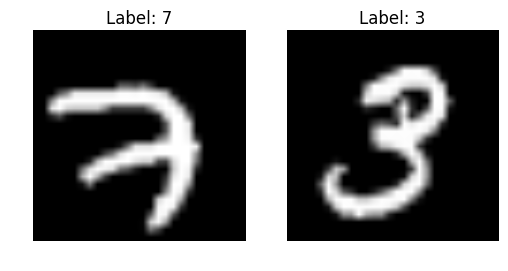

In [10]:
image1 = trX[0, :, :, :]
plt.subplot(1, 2, 1)
plt.imshow(trX[0, :].reshape(28, 28), cmap='gray')
plt.title('Label: {}'.format(np.argmax(trY[0, :])))
plt.axis('off')

image2 = trX[1, :, :, :]
plt.subplot(1, 2, 2)
plt.imshow(trX[1, :].reshape(28, 28), cmap='gray')
plt.title('Label: {}'.format(np.argmax(trY[1, :])))
plt.axis('off')

plt.show()

### Visualize layer1
- `w = init_weights([3, 3, 1, 32])       # 3x3x1 conv, 32 outputs`

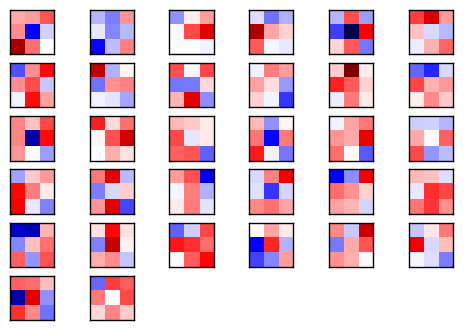

In [11]:
plot_conv_weights(weights=w, input_channel=0)

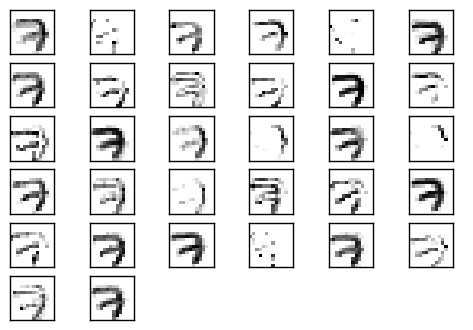

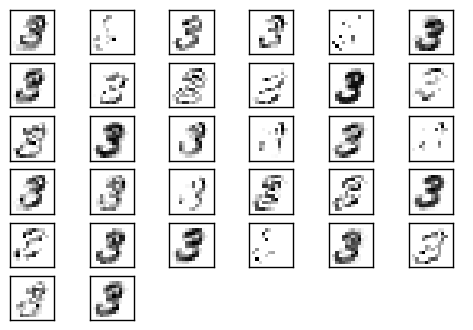

In [12]:
plot_conv_layer(layer=layer1, image=image1)
plot_conv_layer(layer=layer1, image=image2)

### Visualize layer2
- `w2 = init_weights([3, 3, 32, 64])     # 3x3x32 conv, 64 outputs`

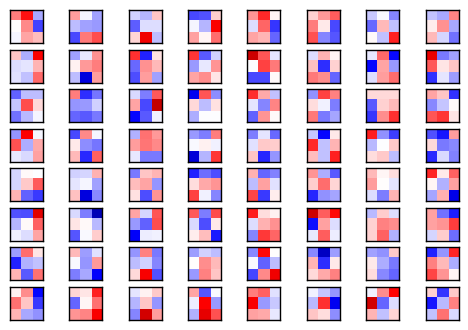

In [14]:
plot_conv_weights(weights=w2, input_channel=1)

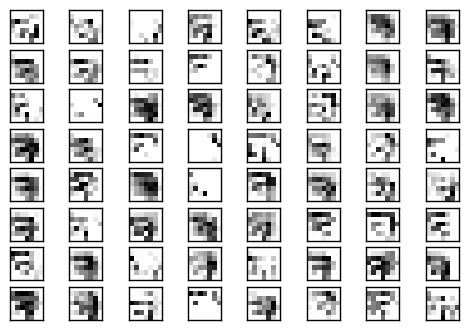

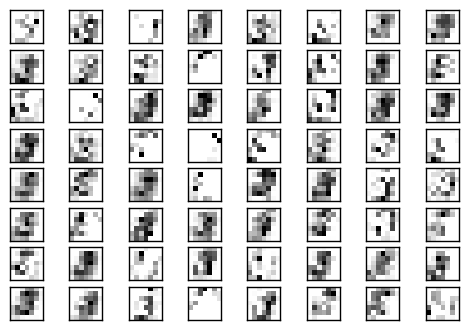

In [15]:
plot_conv_layer(layer=layer2, image=image1)
plot_conv_layer(layer=layer2, image=image2)

### Visualize layer3
- `w3 = init_weights([3, 3, 64, 128])    # 3x3x32 conv, 128 outputs`

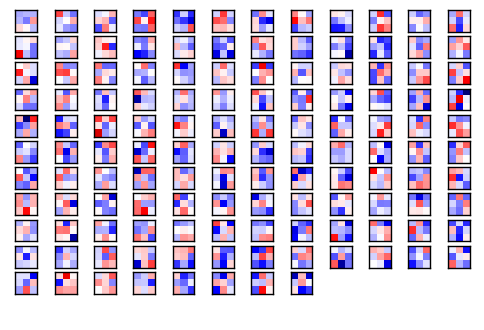

In [16]:
plot_conv_weights(weights=w3, input_channel=0)

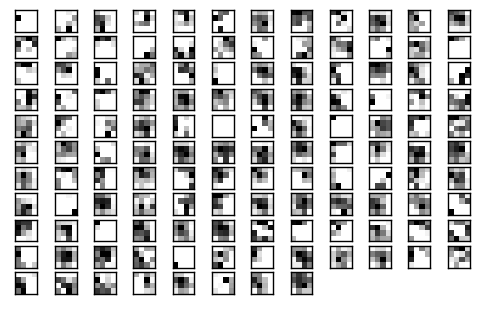

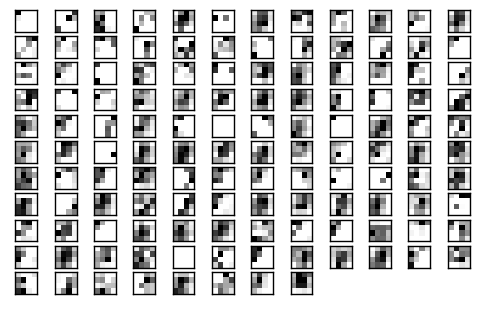

In [17]:
plot_conv_layer(layer=layer3, image=image1)
plot_conv_layer(layer=layer3, image=image2)

In [16]:
sess.close()

### Homework
- Add tensorboard summary

In [7]:
import queue

ImportError: No module named queue